In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [161]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [16]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [17]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [18]:
# We can view all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

In [87]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [44]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [93]:
# Calculate the date 1 year ago from the last data point in the database
last_date = engine.execute('SELECT MAX(date) FROM measurement')
for r in last_date:
    print(r)

('2017-08-23',)


In [94]:
lastDate = session.query(func.max(Measurement.date))
for d in lastDate:
    print(d)

('2017-08-23',)


In [154]:
# Perform a query to retrieve the data and precipitation scores
results = engine.execute('SELECT date, prcp FROM measurement')

In [155]:
# Save the query results as a Pandas DataFrame and set the index to the date column
result_df = pd.DataFrame(results, columns = ['date', 'precipation'])
result_df.set_index('date', inplace=True)
result_df.head()

,precipation
date,
2010-01-01,0.08
2010-01-02,0.00
2010-01-03,0.00
2010-01-04,0.00
2010-01-06,NaN


In [156]:
# Sort the dataframe by date(index)
result_df = result_df.sort_index()

In [157]:
last_12mo_df = result_df.loc[result_df.index >= '2016-08-23']
last_12mo_df 

,precipation
date,
2016-08-23,NaN
2016-08-23,0.00
2016-08-23,0.70
2016-08-23,1.79
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


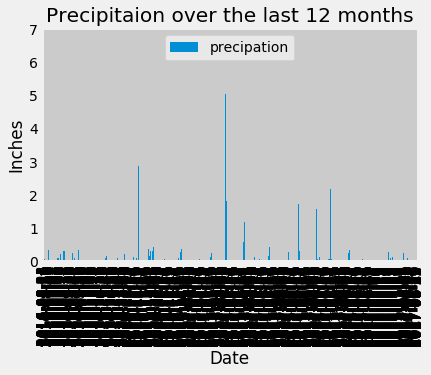

In [158]:
# Use Pandas Plotting with Matplotlib to plot the data
last_12mo_df.plot(kind="bar", title= "Precipitaion over the last 12 months")

plt.ylabel("Inches")
plt.xlabel("Date")
plt.tight_layout
plt.xticks(rotation=90)
plt.show()

In [38]:

# Use Pandas to calcualte the summary statistics for the precipitation data

In [164]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(distinct(Measurement.station)).count()
print(num_stations)

9


In [172]:
station_list= session.query(distinct(Measurement.station))
for station in station_list:
    print(station)

('USC00519397',)
('USC00513117',)
('USC00514830',)
('USC00517948',)
('USC00518838',)
('USC00519523',)
('USC00519281',)
('USC00511918',)
('USC00516128',)


In [173]:
# Load to dataframe
query_all = engine.execute('SELECT station, date, prcp, tobs FROM measurement')
all_df = pd.DataFrame(query_all, columns = ['Station','Date', 'Precipation', 'Temperature' ])

In [175]:
all_df.head()

,Station,Date,Precipation,Temperature
0,USC00519397,2010-01-01,0.08,65.0
1,USC00519397,2010-01-02,0.00,63.0
2,USC00519397,2010-01-03,0.00,74.0
3,USC00519397,2010-01-04,0.00,76.0
4,USC00519397,2010-01-06,NaN,73.0


In [198]:
# group by station
byStation = all_df.groupby("Station")["Temperature"]
summary_stat_byStation = byStation.describe()
summary_stat_byStation

,count,mean,std,min,25%,50%,75%,max
Station,,,,,,,,
USC00511918,1979.0,71.615968,5.476309,53.0,68.0,72.0,75.0,87.0
USC00513117,2709.0,72.689184,3.624668,59.0,70.0,73.0,75.0,85.0
USC00514830,2202.0,74.873297,3.812367,58.0,72.0,75.0,78.0,85.0
USC00516128,2612.0,70.915008,3.523904,58.0,69.0,71.0,73.0,84.0
USC00517948,1372.0,74.684402,4.383041,58.0,72.0,75.0,78.0,87.0
USC00518838,511.0,72.724070,4.144946,58.0,70.0,73.0,76.0,83.0
USC00519281,2772.0,71.663781,4.357642,54.0,69.0,72.0,74.0,85.0
USC00519397,2724.0,74.553231,4.629627,56.0,72.0,76.0,78.0,87.0
USC00519523,2669.0,74.543649,4.323161,56.0,72.0,75.0,77.0,85.0


In [218]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = byStation.count().sort_values(ascending=False)
print(f"Most active station is USC00519281")
print('-----------------------------')
print('Number of observation of temperature')
print('-----------------------------')
print(active_station)

Most active station is USC00519281
-----------------------------
Number of observation of temperature
-----------------------------
Station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: Temperature, dtype: int64


In [233]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
Station_df =  all_df.loc[all_df['Station']=="USC00519281",'Temperature']
Lowest_temp =  Station_df.min()
print(f'Lowest temperature is {Lowest_temp}.')
Highest_temp = Station_df.max()
print(f'Highest temperature is {Highest_temp}.')
Average_temp = round(Station_df.mean(),2)
print(f'Average temperature is {Average_temp}.')

Lowest temperature is 54.0.
Highest temperature is 85.0.
Average temperature is 71.66.


In [236]:
all_df.head()

,Station,Date,Precipation,Temperature
0,USC00519397,2010-01-01,0.08,65.0
1,USC00519397,2010-01-02,0.00,63.0
2,USC00519397,2010-01-03,0.00,74.0
3,USC00519397,2010-01-04,0.00,76.0
4,USC00519397,2010-01-06,NaN,73.0


In [240]:
Station_last_12mo = all_df.loc[(all_df['Station']=="USC00519281") & (all_df['Date'] > '2016-08-23'),'Temperature']

In [241]:
Station_last_12mo

14608    77.0
14609    80.0
14610    80.0
14611    75.0
14612    73.0
         ... 
14954    77.0
14955    77.0
14956    76.0
14957    76.0
14958    79.0
Name: Temperature, Length: 351, dtype: float64

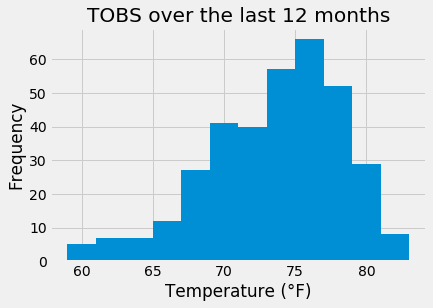

In [243]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(Station_last_12mo, bins =12)
plt.title('TOBS over the last 12 months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
